In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



# Load the files

In [2]:
loandf = pd.read_csv("loan.csv")
dictdf = pd.read_excel("Data_Dictionary.xlsx")

# Understand the Structrue

In [3]:
loandf.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### Loan dataset is of size 39717 * 111. Analsying 111 columns is huge task. Remove unwanted columns

In [4]:
loandf.shape

(39717, 111)

In [5]:
print(loandf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
None


## Find out percentage of null entries in each column. Remove columsn if more than 30% of entries are null

In [6]:
nullInfo = round(100 *(loandf.isnull().sum()/len(loandf.index)), 2)
print(nullInfo)

id                              0.0
member_id                       0.0
loan_amnt                       0.0
funded_amnt                     0.0
funded_amnt_inv                 0.0
                              ...  
tax_liens                       0.1
tot_hi_cred_lim               100.0
total_bal_ex_mort             100.0
total_bc_limit                100.0
total_il_high_credit_limit    100.0
Length: 111, dtype: float64


In [7]:
#Remove columns which are having more than 30% of empty values
nullCol = nullInfo[nullInfo>30].keys()
loandf = loandf.drop(nullCol,axis=1)
loandf.shape

(39717, 53)

In [8]:
nullInfo = round(100 *(loandf.isnull().sum()/len(loandf.index)), 2)
print(nullInfo)

id                            0.00
member_id                     0.00
loan_amnt                     0.00
funded_amnt                   0.00
funded_amnt_inv               0.00
term                          0.00
int_rate                      0.00
installment                   0.00
grade                         0.00
sub_grade                     0.00
emp_title                     6.19
emp_length                    2.71
home_ownership                0.00
annual_inc                    0.00
verification_status           0.00
issue_d                       0.00
loan_status                   0.00
pymnt_plan                    0.00
url                           0.00
purpose                       0.00
title                         0.03
zip_code                      0.00
addr_state                    0.00
dti                           0.00
delinq_2yrs                   0.00
earliest_cr_line              0.00
inq_last_6mths                0.00
open_acc                      0.00
pub_rec             

In [9]:
nullInfo = loandf.isnull().sum(axis=1)
nullRows = nullInfo[nullInfo>5].keys()
print(len(nullRows))

0


## Still some of columns are having NULL values. Either impute with meaningful values or remove columns if not needed

In [10]:
loandf.loc[pd.isnull(loandf['emp_title']),['emp_title']] = "Job_NotDefined"
loandf['emp_title'].value_counts()

Job_NotDefined                     2459
US Army                             134
Bank of America                     109
IBM                                  66
AT&T                                 59
                                   ... 
AMEC                                  1
lee county sheriff                    1
Bacon County Board of Education       1
Hotpads                               1
Evergreen Center                      1
Name: emp_title, Length: 28821, dtype: int64

In [11]:
#Some of the columns are not used in out analysis. Either Drop them or ignore theam.
colNotUseful = ['member_id','pymnt_plan','url','zip_code','addr_state','emp_title']


In [12]:
loandf['emp_length'].value_counts()


10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64

In [13]:
#impute emp_length to -1 wherever its NULL
loandf['emp_length'] =loandf['emp_length'].apply(lambda x:int(str(x).replace('year','').replace('s','').replace('<','').replace('+','').replace('nan','0')))
loandf.loc[loandf['emp_length']==0,['emp_length']] = -1


#Segregate dti continuous column to categorical column
loandf['dti_categories'] = pd.cut(x=loandf['dti'], bins=[0,5, 10, 15, 20,25,30], 
                     labels=['Verylow(0-5)', 'low(5-10)', 'med(10-15)', 
                             'abomed(15-20)','high(20-25)','veryhig(25-30)']) 

#Segregate loan_status categorical column to continuous column
def loanstatusvalues(x):
    if x=='Fully Paid':
        return 0
    elif x=='Charged Off':
        return 2
    else:
        return 1
    
loandf['loan_status_cont']=loandf['loan_status'].apply(loanstatusvalues)

#Segregate grade categorical column to continuous column
def gradevalues(x):
    if x=='A':
        return 1
    if x=='B':
        return 2
    if x=='C':
        return 3
    if x=='D':
        return 4
    if x=='E':
        return 5
    if x=='F':
        return 6
    if x=='G':
        return 7
    return 0


loandf['grade_cont']=loandf['grade'].apply(gradevalues)


In [14]:
#Remove Null entries
colHasNull=['pub_rec_bankruptcies','last_pymnt_d','last_credit_pull_d','revol_util','title']

for col in loandf:
    loandf = loandf[~ loandf[col].isnull()]

#Drop unwanted columns
#colToDrop=['id','member_id','collections_12_mths_ex_med','chargeoff_within_12_mths']
colToDrop = [
   'member_id',
   'url',
   'title',
   'emp_title',
   'zip_code',
   'tax_liens',
   'acc_now_delinq',
   'chargeoff_within_12_mths',
   'delinq_amnt',
   'application_type',
   'policy_code',
   'initial_list_status',
   'installment',
   'pymnt_plan',
   'collections_12_mths_ex_med',
   'total_pymnt',
   'out_prncp',
   'total_rec_prncp',
   'total_rec_int',
   'last_pymnt_d',
   'last_pymnt_amnt',
   'last_credit_pull_d'
]
for col in colToDrop:
    loandf = loandf.drop(col,axis=1)
    

loandf.isnull().sum()

id                         0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
grade                      0
sub_grade                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp_inv              0
total_pymnt_inv            0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
pub_rec_bankruptcies       0
dti_categories             0
loan_status_cont           0
grade_cont                 0
dtype: int64

count    38729.000000
mean       690.555145
std        628.495079
min         40.000000
25%        409.887600
50%        595.000000
75%        825.700000
max      60000.000000
Name: annual_inc, dtype: float64


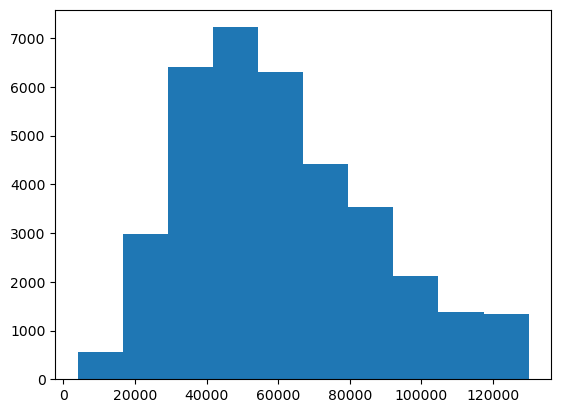

In [15]:
print((loandf['annual_inc']/100).describe())

#annual_inc column has outliers. Remove them 
loandf = loandf[(loandf['annual_inc']>=4000) & (loandf['annual_inc']<=130000  ) ]
loandf['income_cat'] = pd.cut(x=loandf['annual_inc'], bins=[0,20000,40000,60000,80000,100000,120000],
                     labels=['0-20K', '20-40K', '40-60K', 
                             '60-80K','80-100K','100K>'])
plt.hist(loandf['annual_inc'])
plt.show()



In [16]:
loandf.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt_inv,total_rec_late_fee,recoveries,collection_recovery_fee,pub_rec_bankruptcies,dti_categories,loan_status_cont,grade_cont,income_cat
0,1077501,5000,5000,4975.0,36 months,10.65%,B,B2,10,RENT,...,0.00,5833.84,0.00,0.00,0.00,0.0,veryhig(25-30),0,2,20-40K
1,1077430,2500,2500,2500.0,60 months,15.27%,C,C4,1,RENT,...,0.00,1008.71,0.00,117.08,1.11,0.0,Verylow(0-5),2,3,20-40K
2,1077175,2400,2400,2400.0,36 months,15.96%,C,C5,10,RENT,...,0.00,3005.67,0.00,0.00,0.00,0.0,low(5-10),0,3,0-20K
3,1076863,10000,10000,10000.0,36 months,13.49%,C,C1,10,RENT,...,0.00,12231.89,16.97,0.00,0.00,0.0,abomed(15-20),0,3,40-60K
4,1075358,3000,3000,3000.0,60 months,12.69%,B,B5,1,RENT,...,524.06,3513.33,0.00,0.00,0.00,0.0,abomed(15-20),1,2,60-80K


In [17]:
# Analyze columns & Segregate them w.r.t Categorical, Continuous columns. 

In [18]:
categoricalCols=['home_ownership','verification_status','loan_status','purpose','dti_categories','income_cat']
                 
continuousCols=['emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc',
                'out_prncp_inv','total_pymnt_inv','loan_status_cont','recoveries','collection_recovery_fee','term','int_rate']


In [19]:
# Replace % with Null for int_rate column & replace 'months' with Null for term column
loandf['int_rate'] = loandf['int_rate'].apply(lambda x:float(x.replace('%','')))
loandf['term'] = loandf['term'].apply(lambda x:int(str(x).replace('months','')))

In [20]:

loandf.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt_inv,total_rec_late_fee,recoveries,collection_recovery_fee,pub_rec_bankruptcies,dti_categories,loan_status_cont,grade_cont,income_cat
0,1077501,5000,5000,4975.0,36,10.65,B,B2,10,RENT,...,0.00,5833.84,0.00,0.00,0.00,0.0,veryhig(25-30),0,2,20-40K
1,1077430,2500,2500,2500.0,60,15.27,C,C4,1,RENT,...,0.00,1008.71,0.00,117.08,1.11,0.0,Verylow(0-5),2,3,20-40K
2,1077175,2400,2400,2400.0,36,15.96,C,C5,10,RENT,...,0.00,3005.67,0.00,0.00,0.00,0.0,low(5-10),0,3,0-20K
3,1076863,10000,10000,10000.0,36,13.49,C,C1,10,RENT,...,0.00,12231.89,16.97,0.00,0.00,0.0,abomed(15-20),0,3,40-60K
4,1075358,3000,3000,3000.0,60,12.69,B,B5,1,RENT,...,524.06,3513.33,0.00,0.00,0.00,0.0,abomed(15-20),1,2,60-80K


# Univariate analysis 

# Categorical columns analysis

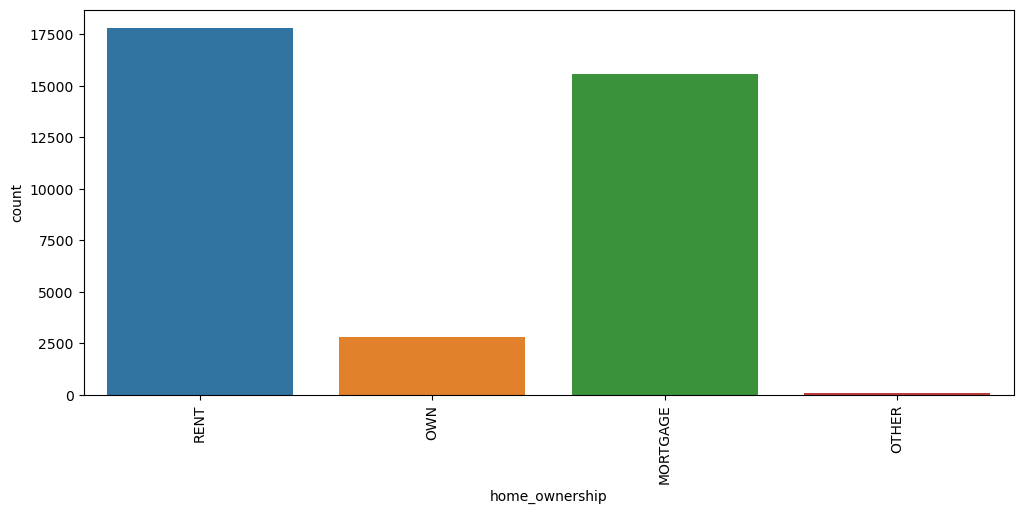

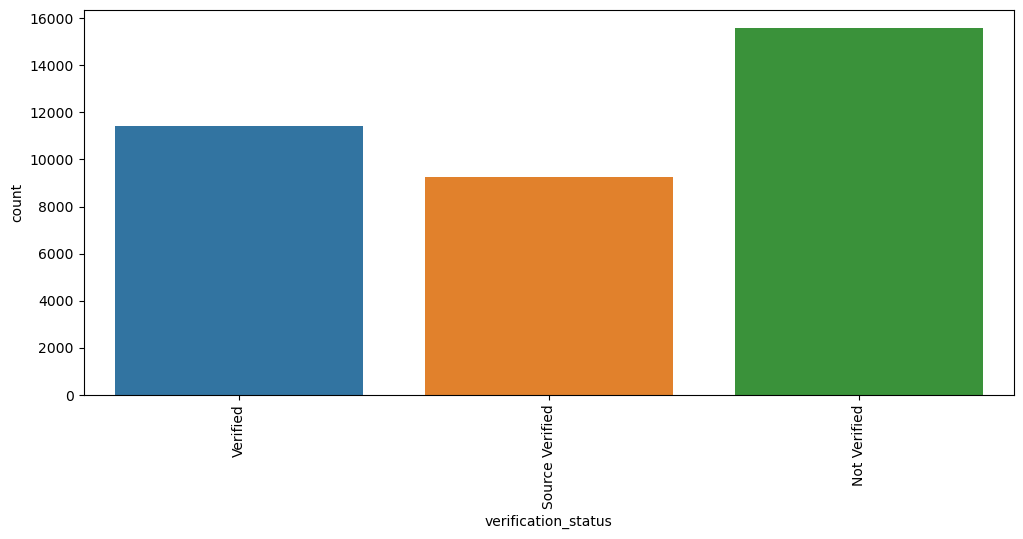

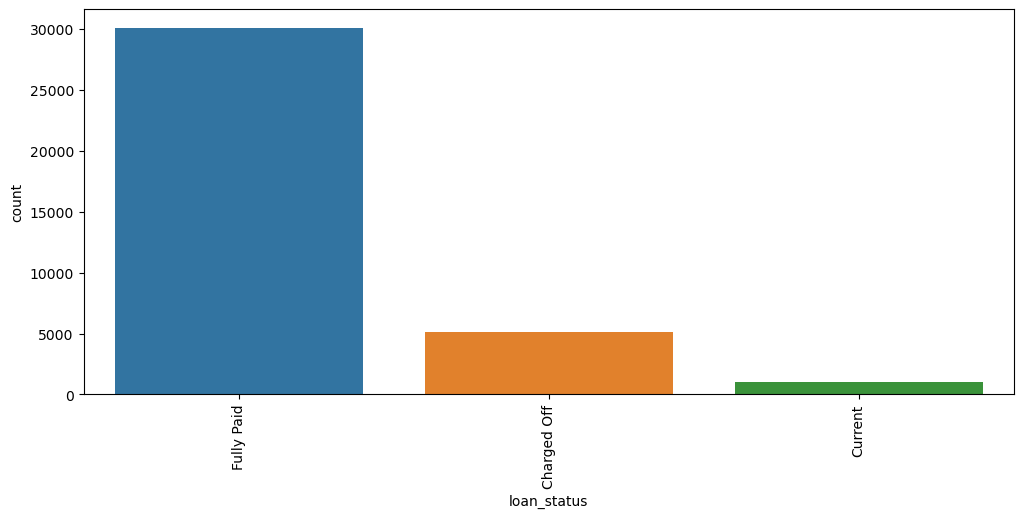

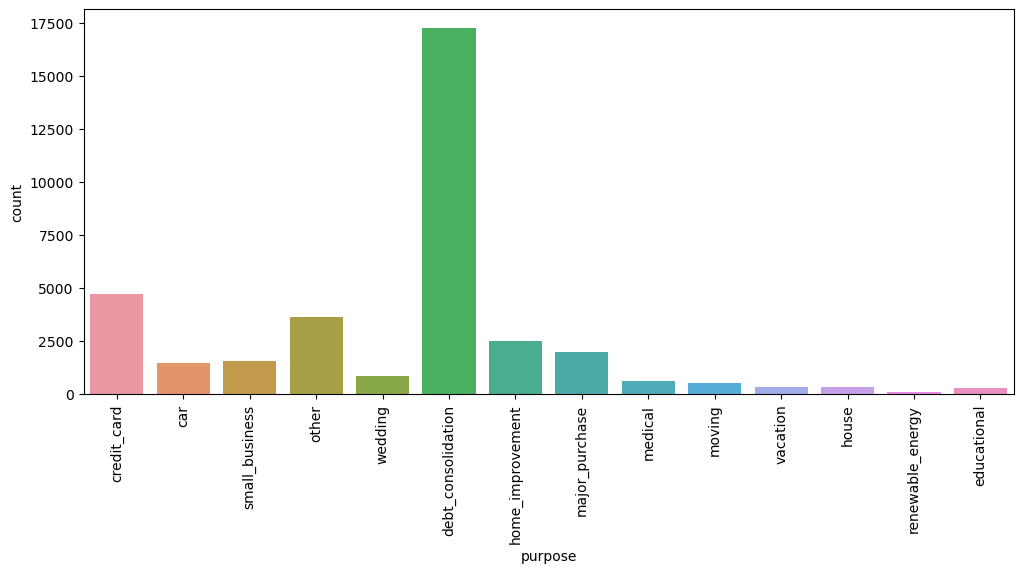

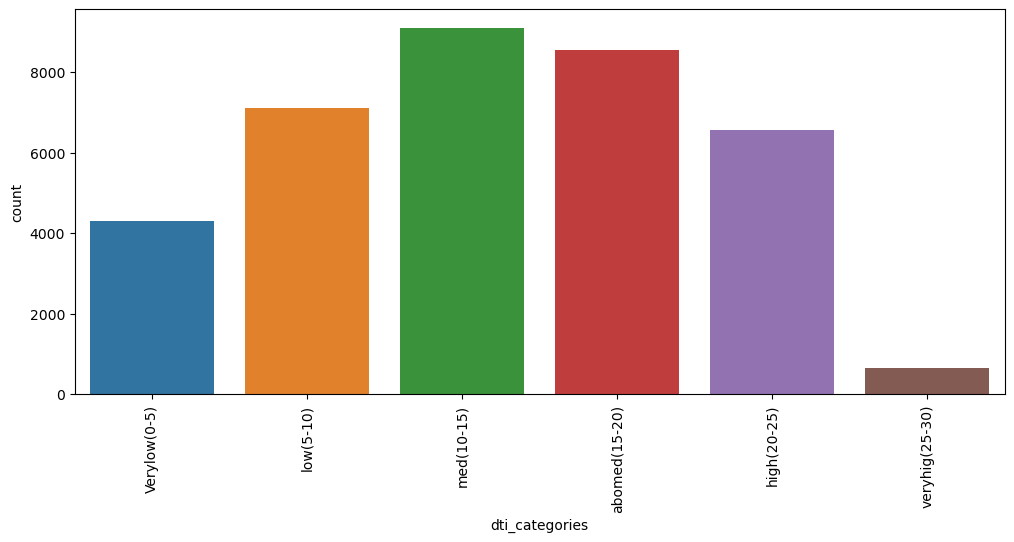

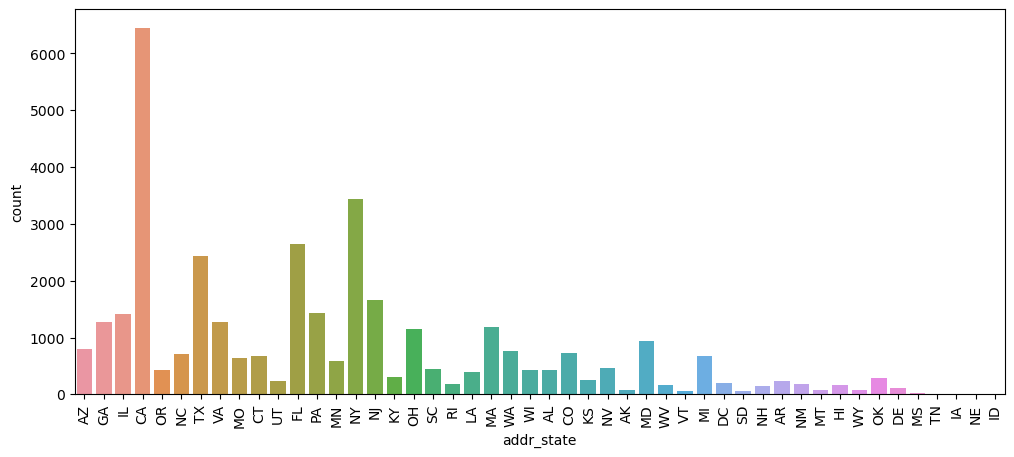

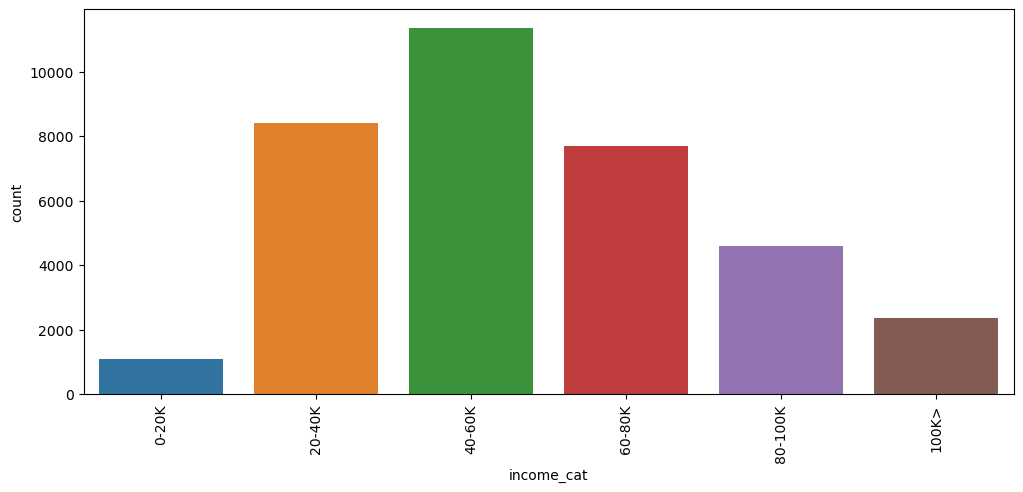

In [21]:

categorCols=['home_ownership','verification_status','loan_status','purpose','dti_categories',
             'addr_state','income_cat']

for col in categorCols:
    plt.figure(figsize=(12,5))
    sns.countplot(x=loandf[col])
    plt.xticks(rotation=90)
    plt.show()

## Categorical columns :Results of analysis
### 1.People who are in Rent or their home is under Mortgage are major loan seekers
### 2.Top reasons for purchasing loans are Debt_consolidation, CreditCard Payments,other, Homeimprovement 
### 3.Among loan applicants still major portion of people are not yet verified. Thats a concern.
### 4.DTI ratio of majority people lies b/w 10 to 25

#### ------------------------
# Continuous Columns Analysis

In [22]:
#Analysing below continuous columns
#continuousCols=['emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc',
#                'out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
#               'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt']

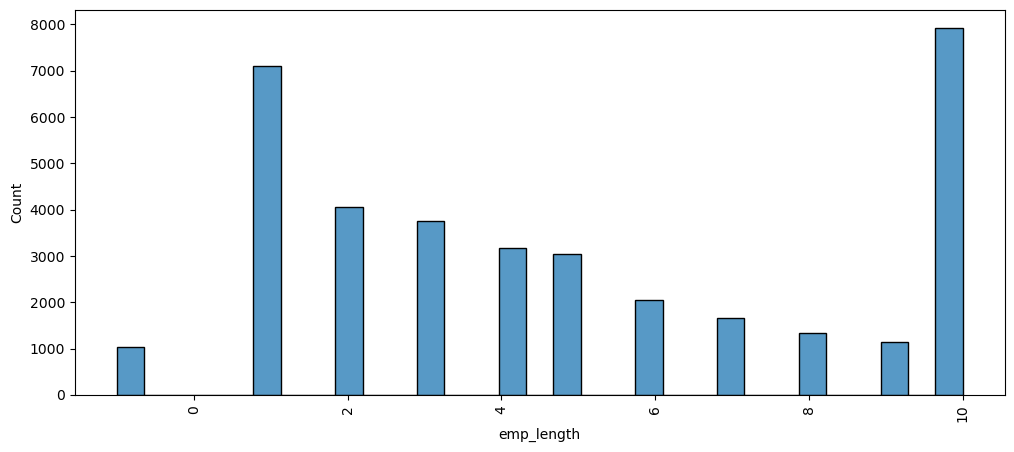

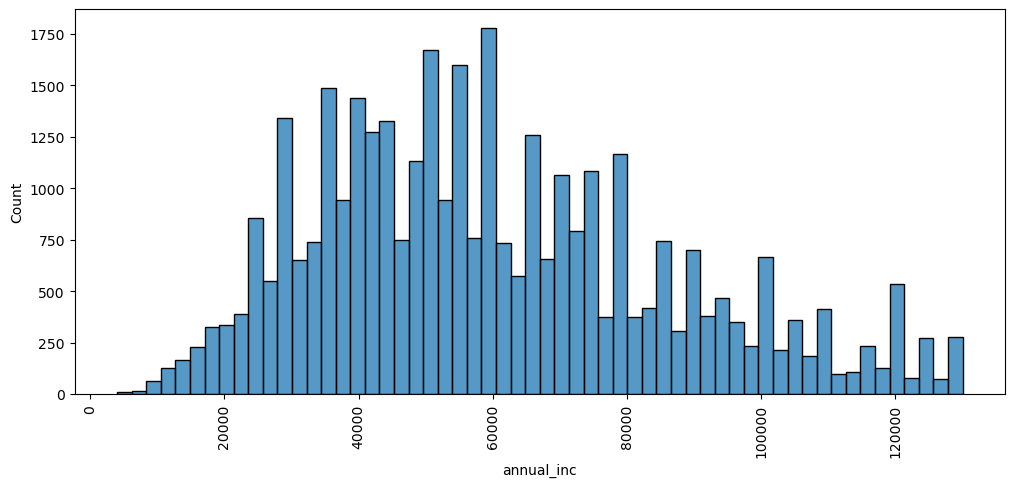

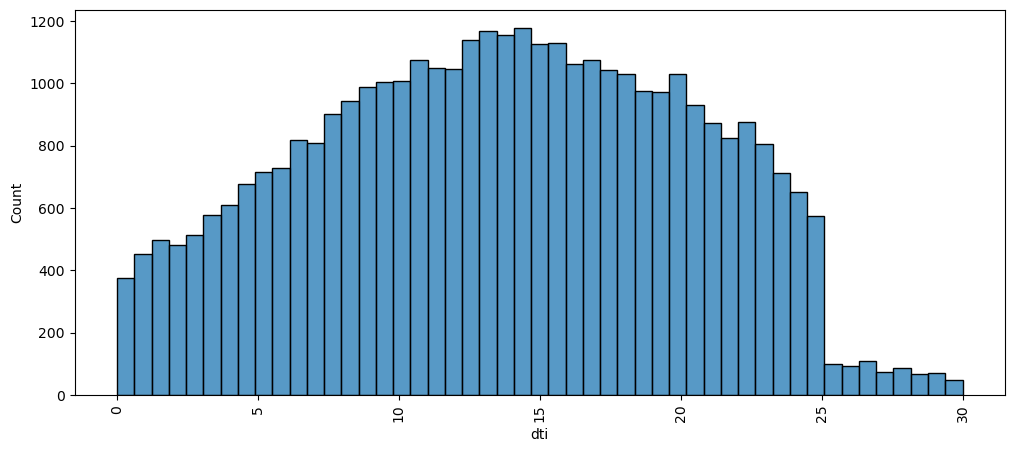

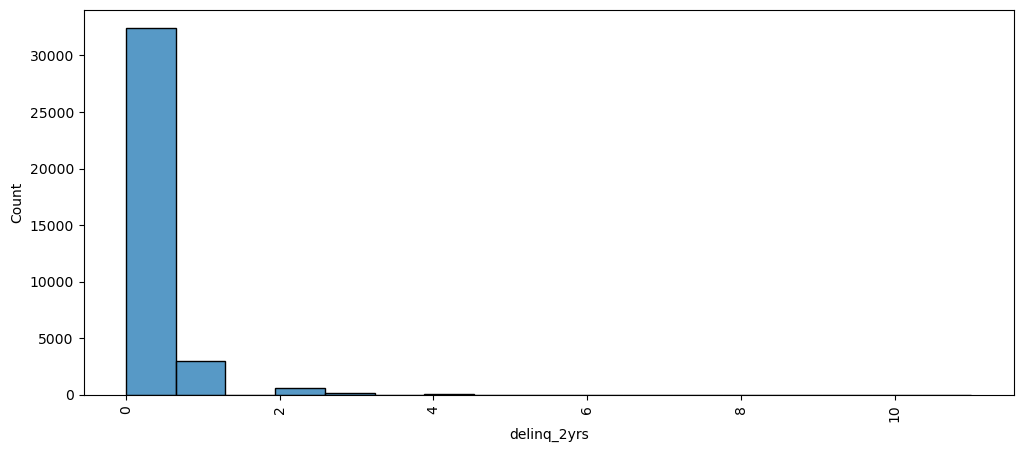

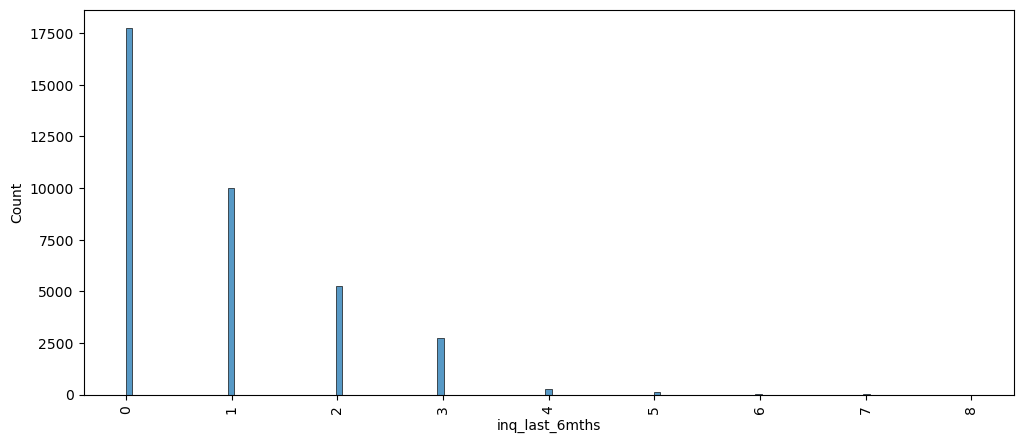

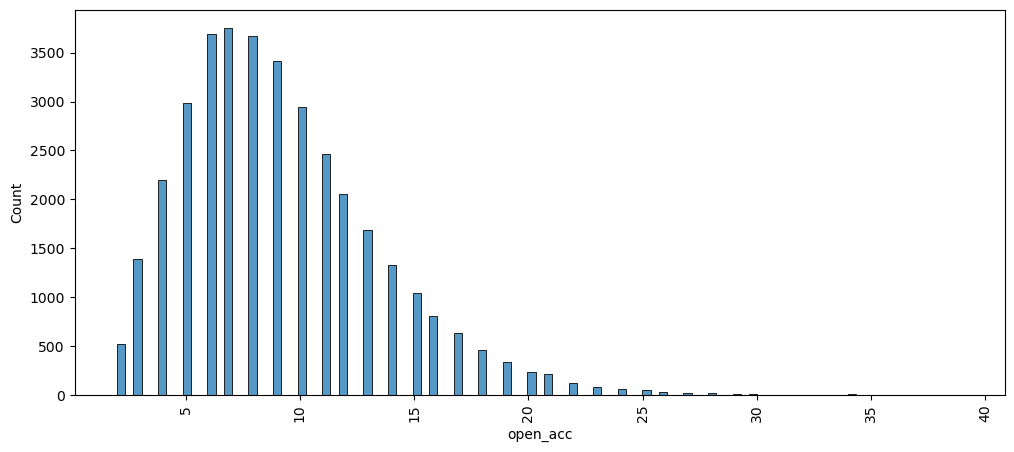

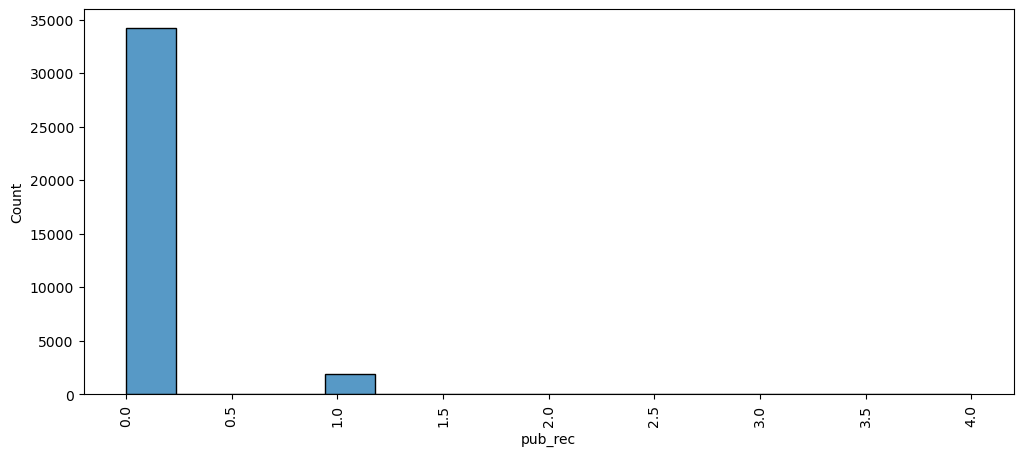

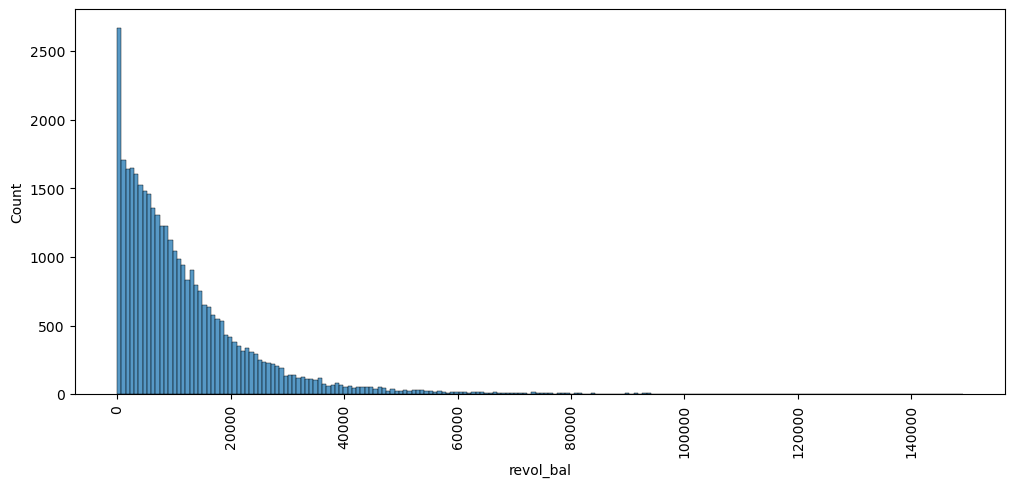

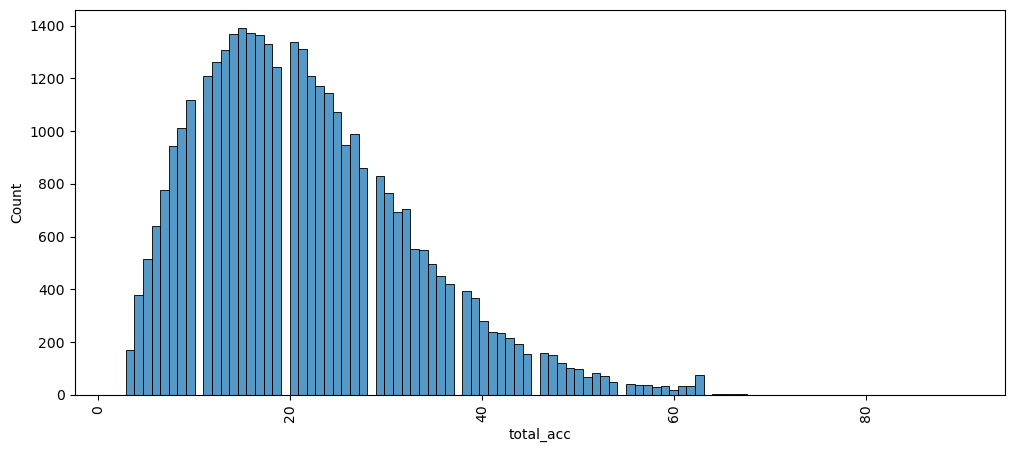

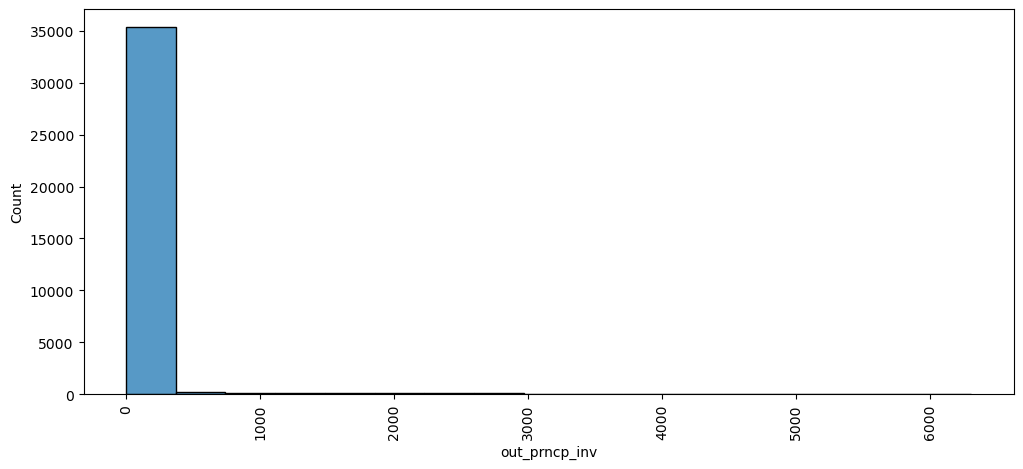

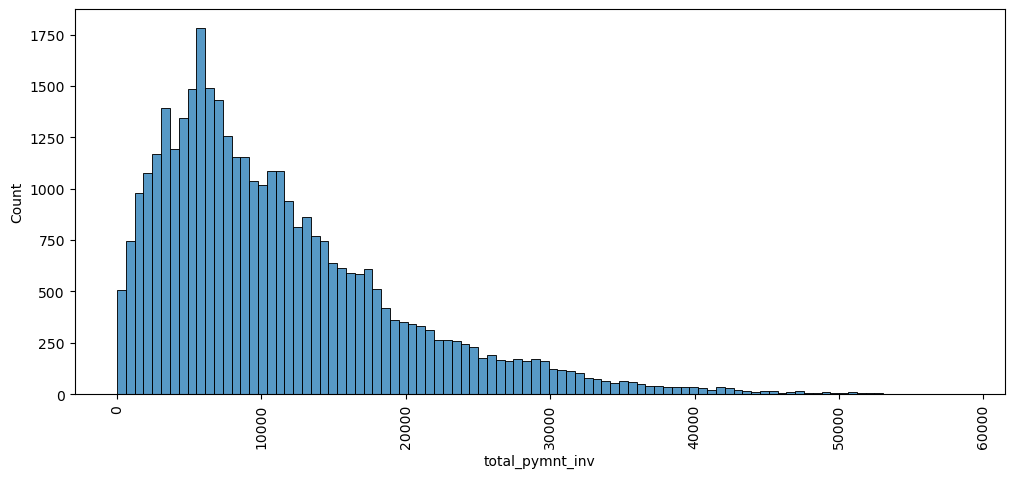

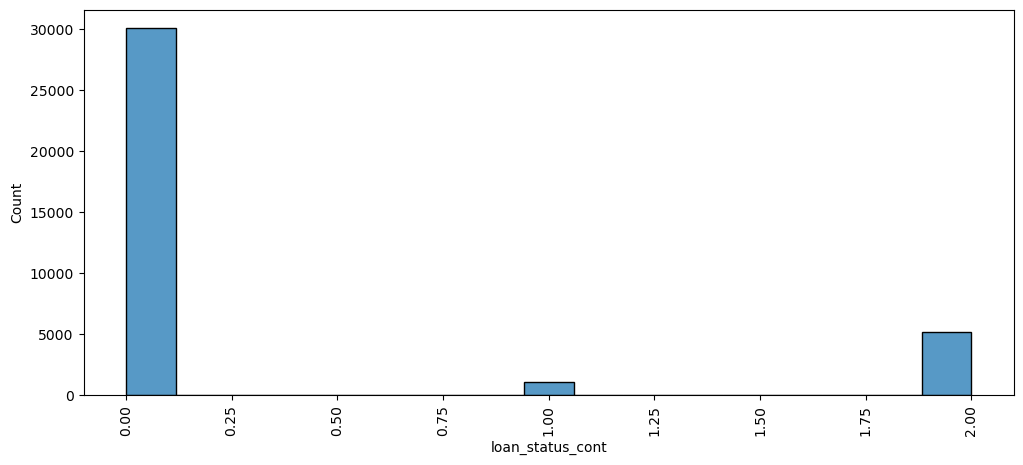

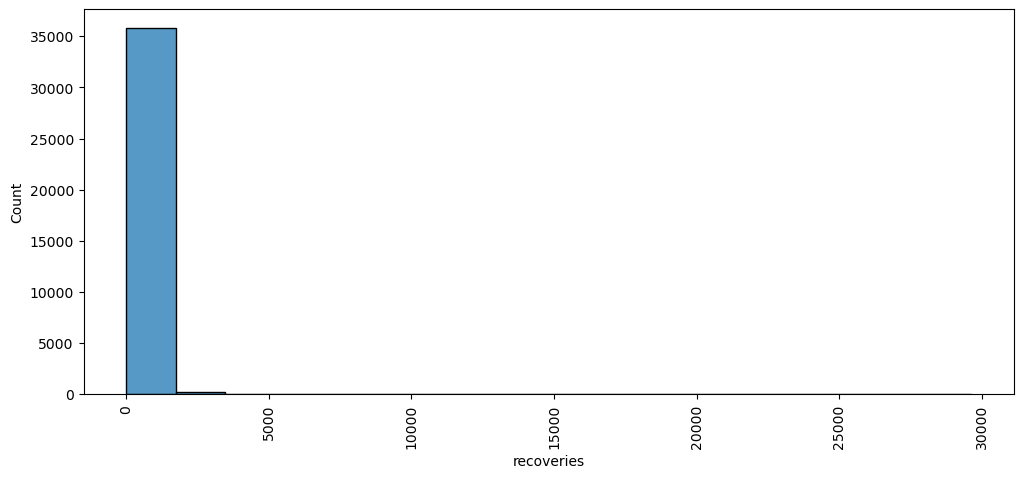

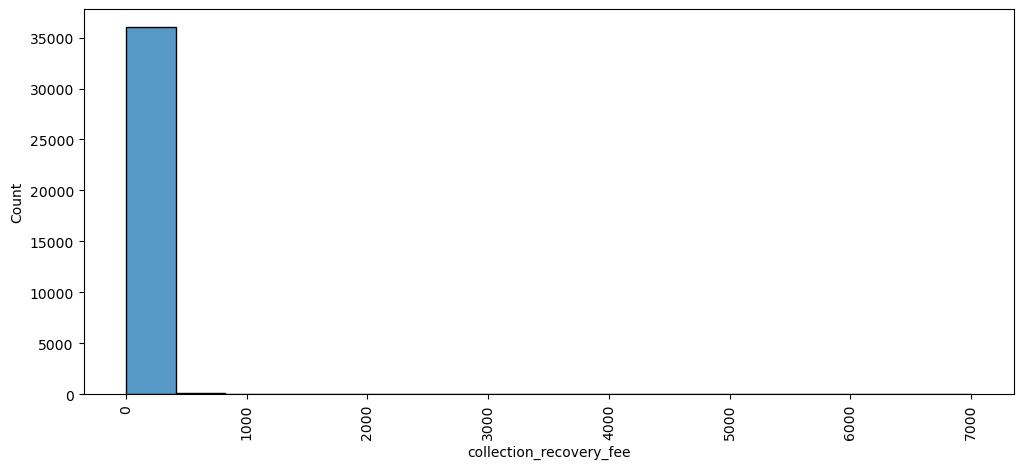

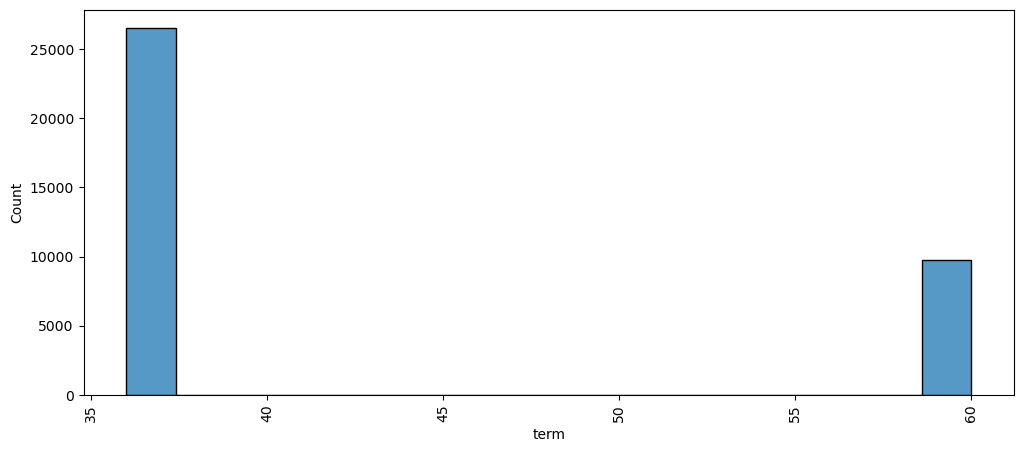

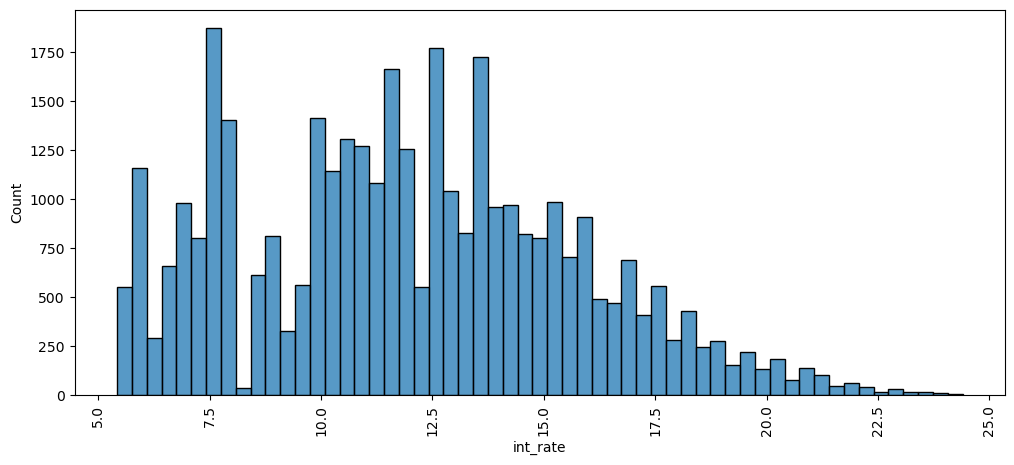

In [23]:

loandf['dti'].value_counts()

for col in continuousCols:
    plt.figure(figsize=(12,5))
    sns.histplot(x=loandf[col])
    plt.xticks(rotation=90)
    plt.show()
    
## Results of analysis
#### Majority of the people are either under 1 year or 10 year of employment length
#### Majority of the people having dti in the ranage of 10 to 25
#### Most of the pople are having total credit lines of around 10 to 20
## ----------------------------

# Bivariate analysis

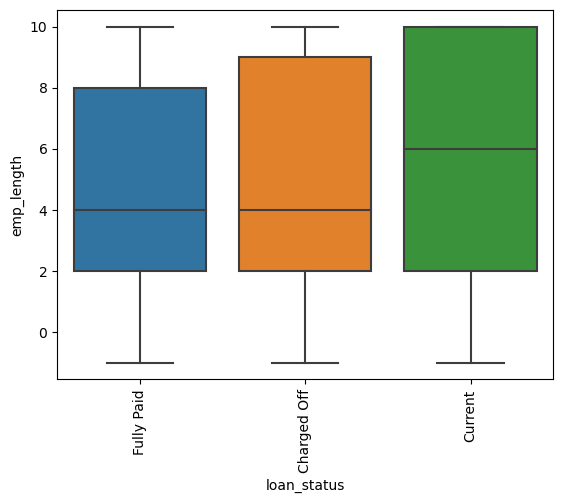

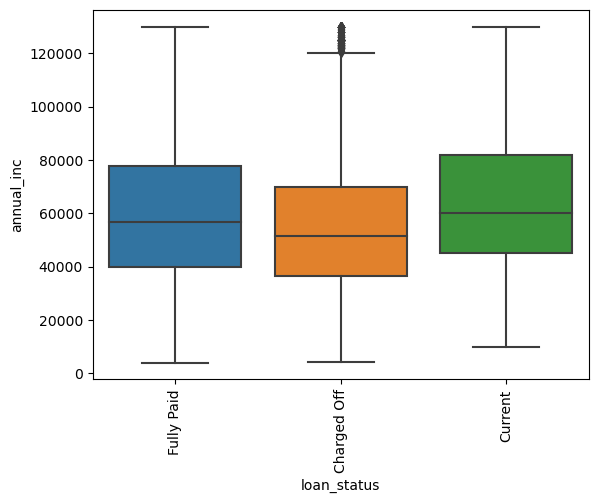

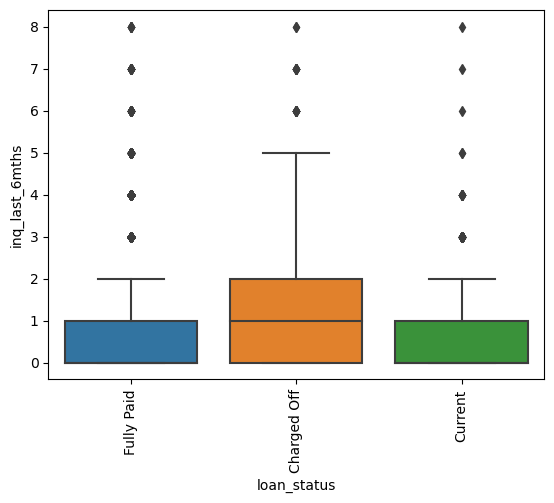

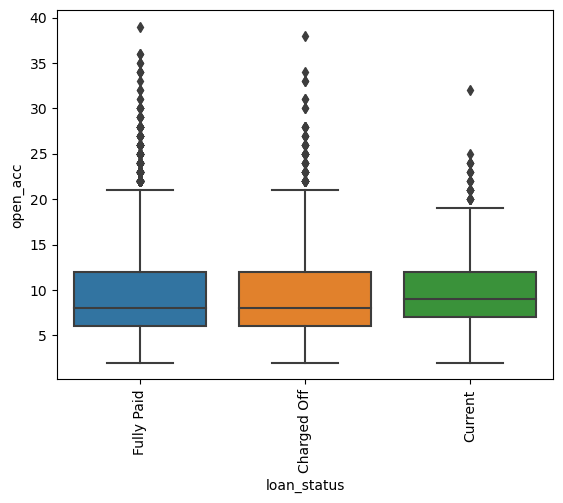

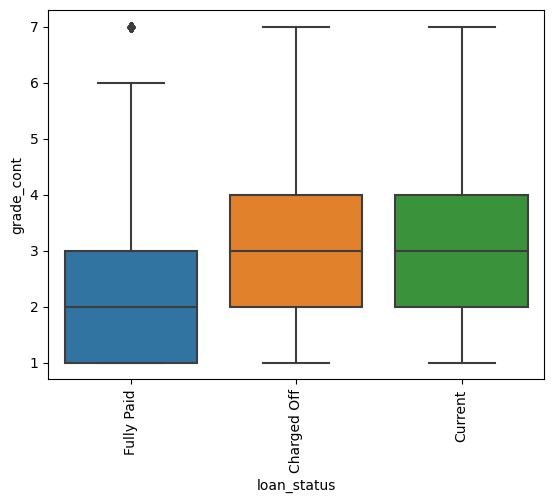

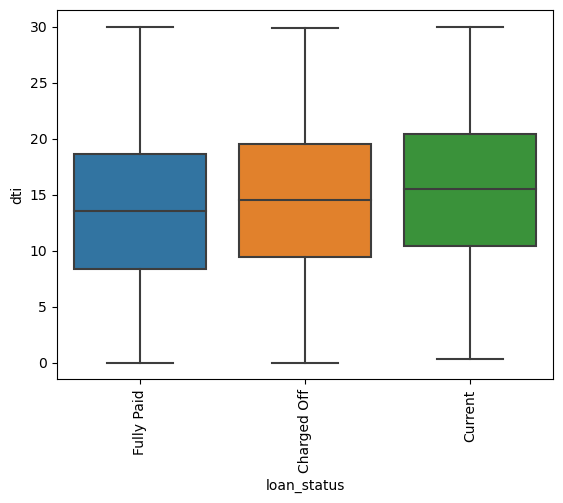

In [24]:

##Continuous vs Categorical

contcols=['emp_length','annual_inc','inq_last_6mths','open_acc','grade_cont','dti']
catcols=['loan_status']

for col1 in catcols:
    for col2 in contcols:
        if col1!=col2:
            sns.boxplot(x=loandf[col1],y=loandf[col2])
            plt.xticks(rotation=90)
            plt.show()

#From below charts
# 1. People with higher value of 'inq_last_6mths' are charged off more
# 2. People with dti of 10 to 20, likely to be 'charged off' 

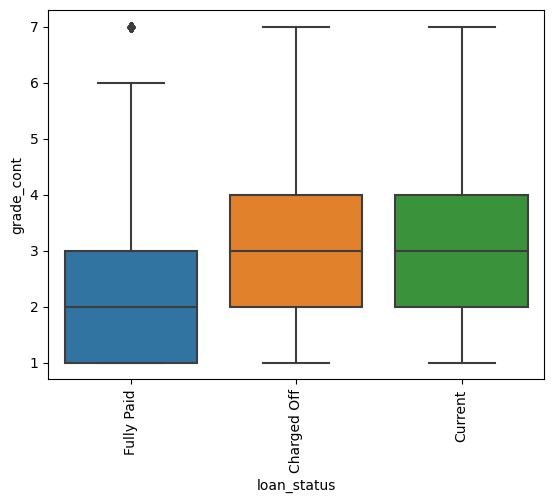

In [25]:
#Among 'Charged Off' candidates, people who have secured loan grade as B, C or D are more likely to default than other categories
# from below charts
defaultersdf = loandf[loandf['loan_status']=='Charged Off']
sns.boxplot(x=loandf['loan_status'],y=loandf['grade_cont'])
plt.xticks(rotation=90)
plt.show()



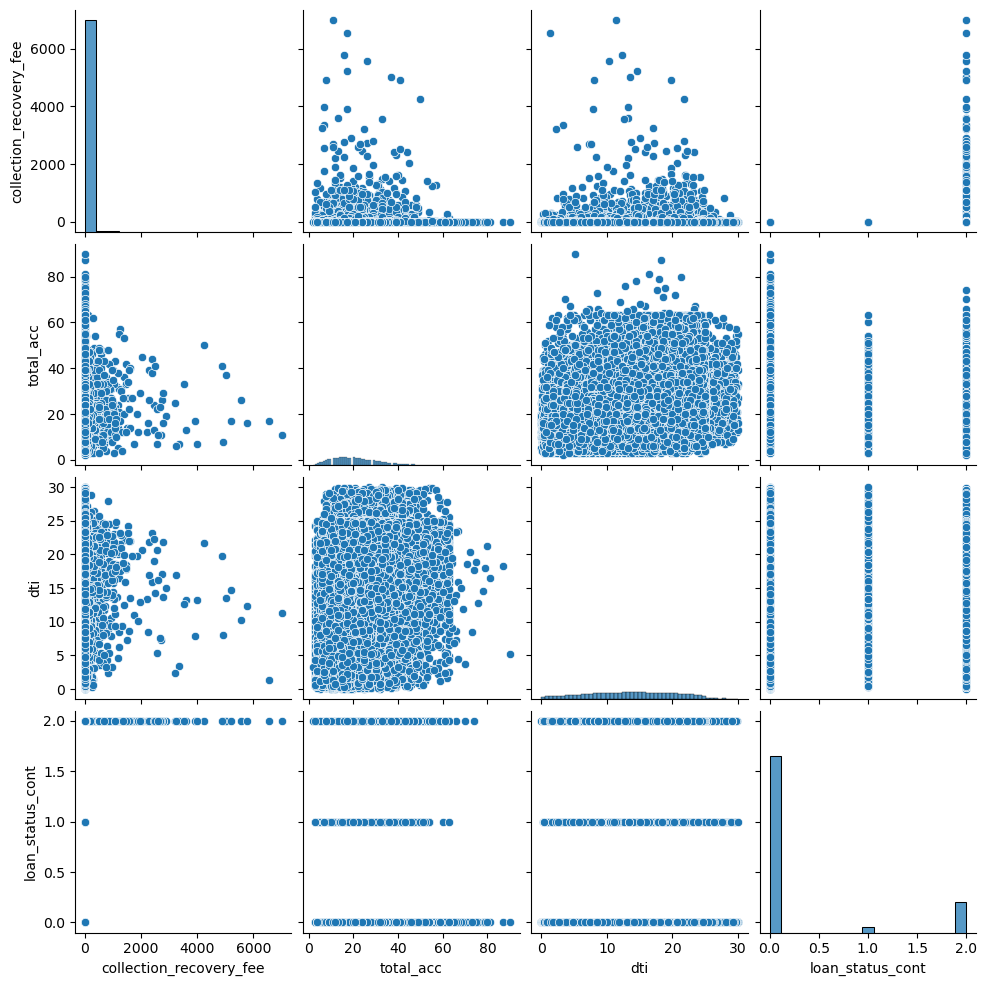

In [26]:
#Continuous vs Continuous columns

contCols=['collection_recovery_fee','total_acc','dti','loan_status_cont']
sns.pairplot(loandf[contCols])
plt.show()
#with the below pair plot hard to analyze the data. So, in below step, filtering out people 
# 1.who have atleast 1 or more public record
# 2.who have collection_recovery_fee greater than 1

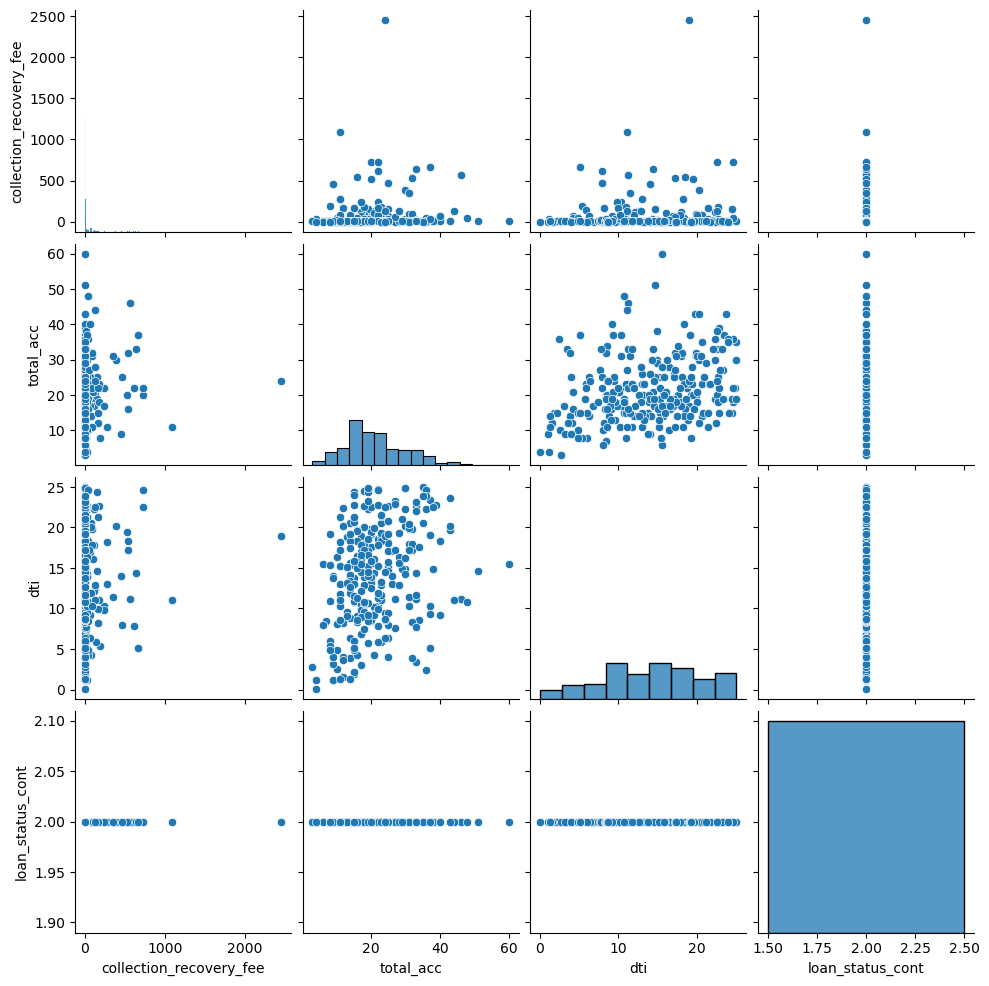

In [27]:
#filtering out people 
# 1.who have atleast 1 or more public record
# 2.who have collection_recovery_fee greater than 1
recoveyPaiddf = loandf[(loandf['collection_recovery_fee']>0) & (loandf['pub_rec']>0)]
sns.pairplot(recoveyPaiddf[contCols])
plt.show()

#Below plots showing Collection Recocery fee is high  whenever dti ratio lies b/w 10 to 20
# total credit lines are high whenever dti ratio lies b/w 10 to 20
#Loan status count=2 stands for 'Charged Off' accoutn, which is clearly high whenever people either paid Collection Recocery fee 
#   or have pub_rec or high dti ratio


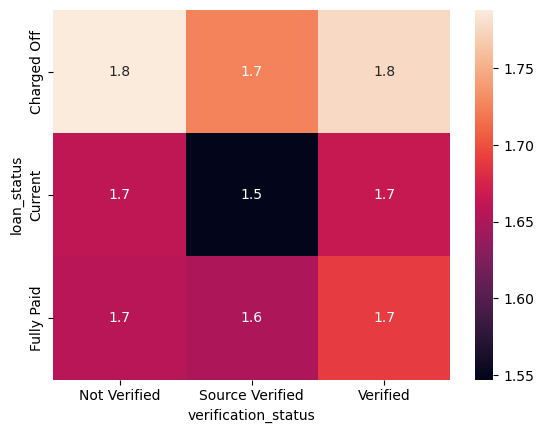

In [28]:
res =pd.pivot_table(data=loandf[(loandf['inq_last_6mths']>0)], index='loan_status', columns="verification_status", values="inq_last_6mths",
                    aggfunc=np.mean)
sns.heatmap(res,annot=True)
plt.show()

#People with Higher inquires in last 6 months have higher probalility of defaulting loan

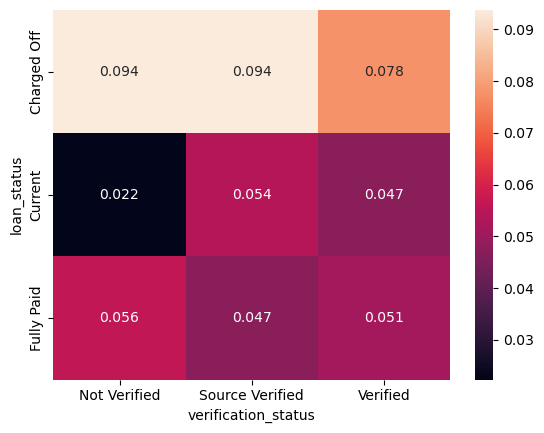

In [29]:
res =pd.pivot_table(data=loandf, index='loan_status', columns="verification_status", values="pub_rec",
                    aggfunc=np.mean)
sns.heatmap(res,annot=True)
plt.show()

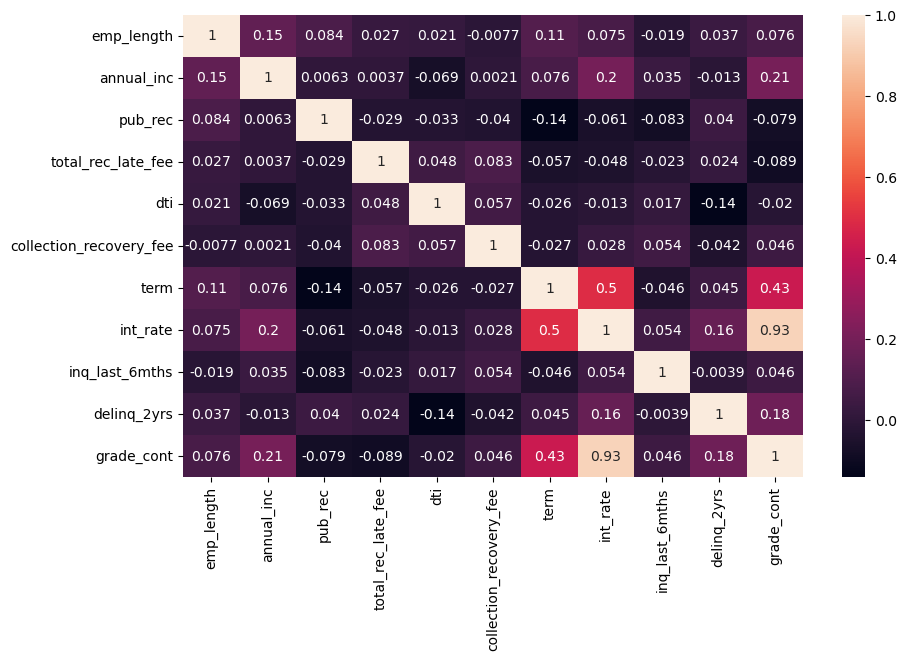

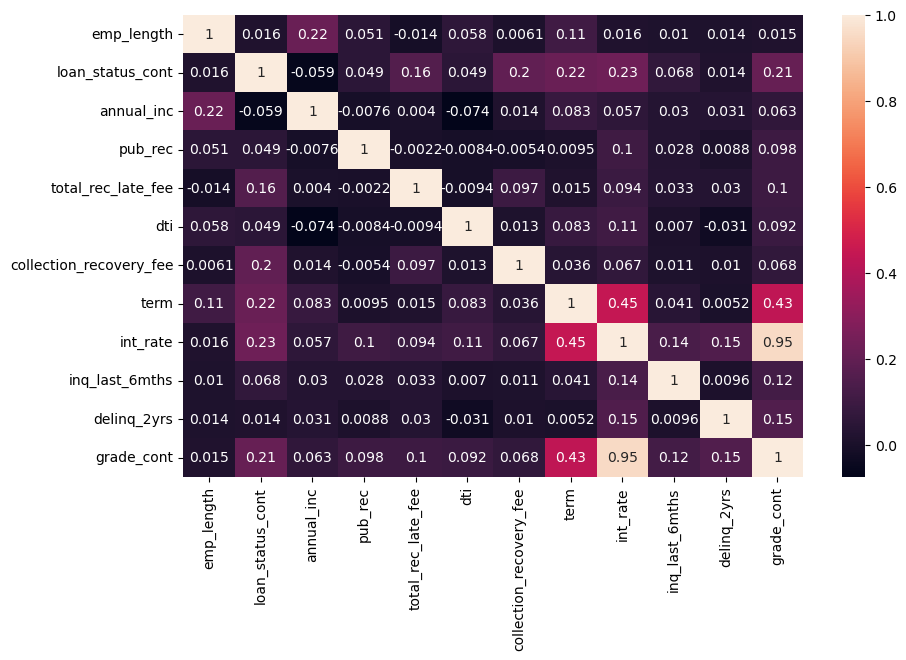

In [30]:
contCols=['emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','pub_rec','revol_bal','total_acc',
                'total_rec_late_fee','recoveries','collection_recovery_fee','term','int_rate','inq_last_6mths']

plt.figure(figsize=(10,6))
sns.heatmap(recoveyPaiddf.loc[:,['emp_length','annual_inc','pub_rec','total_rec_late_fee','dti',
                          'collection_recovery_fee','term','int_rate','inq_last_6mths','delinq_2yrs','grade_cont']].corr(),annot=True)
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(loandf.loc[:,['emp_length','loan_status_cont','annual_inc','pub_rec','total_rec_late_fee','dti',
                          'collection_recovery_fee','term','int_rate','inq_last_6mths','delinq_2yrs','grade_cont']].corr(),annot=True)
plt.show()



In [31]:
#Final analysis outcomes

# 1. Majority of 'Charged Off' loans belongs to Loan Grade B, C or D
# 2. People who are paying 'collection_recovery_fee' are more likely to get ino 'Charged Off' the loan
# 3. People who have Derogatory pulic records (i.e column pub_rec) are more likely to get ino 'Charged Off' the loan
# 4. People with dti ratio lies b/w 10 to 20 are likely to 'Charged Off' the loan
# 5. People who enquired inquired more than 1 times i.e (columns : inq_last_6mths), in last 6 months have higher probability of defaulting loan
# 6. People whose Verification status as ‘Source Verified’ are less likely to default than people with other verifications status
